# Linear Regression

Yesterday, we talked about solutions $w$ of size $n$ of the matrix equation $Xw=y$, given some data matrix $X$ of size $m \times n$ and a vector $y$ of size $m$, so that we have $m$ samples each with $n$ features. 
Let's start by randomly generating some data and solving for the solution using the normal equation for linear regression.

We know that
$$X^TXw=X^TY$$

And when $X^TX$ is invertible, then we have a unique solution $w^*$

$$w^*=(X^TX)^{-1} X^T y$$

In [51]:
import autograd.numpy as np
import autograd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

I'm generating data here; our intercept is 7 and slope is 13. It's worth noting that I'm adding a column to X that is all ones, something you have to do depending on how you're solving for your parameters.

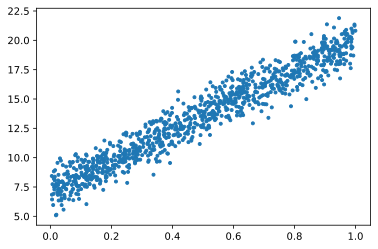

In [52]:
w = np.array([7, 13])

np.random.seed(42)
XnoInt = np.random.uniform(0, 1, size=(1000,))
X = np.stack([np.ones(1000), XnoInt], axis=1)
Y = X@w + np.random.normal(size=XnoInt.shape)
plt.plot(XnoInt, Y, '.');

Let's solve for our parameters! Looks pretty good.

In [53]:
np.linalg.pinv(X.T @ X) @ X.T @ Y

array([ 7.17478026, 12.84521484])

When working with real data, there are often no solutions due to noisiness of our data. We can notice that $Xw=y$ perfectly minimizes $\|Xw-y\|_2$, suggesting a relaxation of our original problem; by minimizing $\|Xw-y\|_2$, maybe we can find an acceptable solution.

# Optimization

Let's try to find the $w^*$ that minimizes $\|Xw-y\|_2$! Since we'll be working through derivatives, I'll introduce new notation to avoid linear algebra since that complicates some of the calculus. I'll also scale things down so we're just working with one feature and an intercept term, so we can visualize everything.

We hope to find a linear mapping between inputs $\{x_i\}^m_{i=1}$ and associated outputs $\{y_i\}^m_{i=1}$. So, we're looking for a $w$ and $b$ that makes good predictions $\hat{y}_i = w x_i+b$. We'll evaluate this based on the mean of the squared error between our predictions $\{\hat{y}_i\}^m_{i=1}$ and the true values $\{y_i\}^m_{i=1}$, which we'll call the loss, or $J(w, b)$. Here are the equations we'll be working with:

\begin{align}
\hat{y}_i &= w x_i+b \\
J(w, b) &= \frac{1}{m} \sum_{i=1}^m (\hat{y}_i-y_i)^2 \\
\end{align}

There are many ways to find the best $w$ and $b$ for this function: You can imagine randomly testing different values, trying all "reasonable" values, or taking a step in many possible directions to see which minimize $J(w, b)$. We can use the derivative of $J(w, b)$ to determine the best direction to change a point to minimize $J(w, b)$.  While the gradient won't always lead you to the best solution, the $J(w, b)$ that we're trying to minimize has very nice theoretical properties that actually guarantee that we'll find the optimal solution! (Though note that this isn't generally the case).

We'll start by working out the derivative of $\hat{y}_i$ w.r.t. $w$ which will be useful when we compute the derivative of loss.

\begin{align}
\frac{d}{dw}\hat{y}_i &= \frac{d}{dw}(wx_i+b) = x_i \\
\frac{d}{db}\hat{y}_i &= \frac{d}{db}(wx_i+b) = 1 \\
\end{align}

To find weights that minimize the loss, we'll find the gradient of the loss $J$ w.r.t. the weight $w$

\begin{align}
\frac{d}{dw} J(w, b) &= \frac{d}{dw} \left( \frac{1}{m} \sum_{i=1}^m (\hat{y}_i-y_i)^2 \right) \\
&= \frac{1}{m} \sum_{i=1}^m \frac{d}{dw} (\hat{y}_i-y_i)^2\\
&= \frac{1}{m} \sum_{i=1}^m 2 (\hat{y}_i-y_i) \frac{d}{dw} (\hat{y}_i-y_i) \\
&= \frac{1}{m} \sum_{i=1}^m 2 (\hat{y}_i-y_i) x_i \\
\end{align}

Following a similar set of steps, you can also figure out that $\frac{d}{db} J(w, b) = \frac{1}{m} \sum_{i=1}^m 2 (\hat{y}_i-y_i)$.

_For the curious_: You might wonder why we minimize the mean squared error! Kind of seems like a hack... Curiously, it is equivalent to a maximum likelihood estimate, assuming the $y_i$ come from a linear model with Gaussian noise added. See [Ryan Adam's COS 324 notes](https://www.cs.princeton.edu/courses/archive/fall18/cos324/files/mle-regression.pdf) or [the Deep Learning textbook](https://www.deeplearningbook.org/contents/ml.html) for derivations.

I referred to [this blog post](https://mccormickml.com/2014/03/04/gradient-descent-derivation/) in working through these derivations.

## Finding a fit...

We'll try to find the parameters of the best linear model. We'll assume we know the intercept $b=7$ and try to solve for $w$ by using $\frac{dJ}{dw}$. We'll minimize our loss $J$ by changing $w$ a small amount based on the gradient $\frac{dJ}{dw}$. We'll then repeat the process on our latest estimate of $w$. We'll let $w_t$ denote the weight $w$ at step $t$ of this process. So our algorithm looks like

$$
w_{t+1} = w_t - \alpha * \frac{dJ}{dw_t}
$$

We'll compute the derivatives, perform gradient descent, and plot the steps (plotted below as colorful dots) it takes to find weight $w=13$.

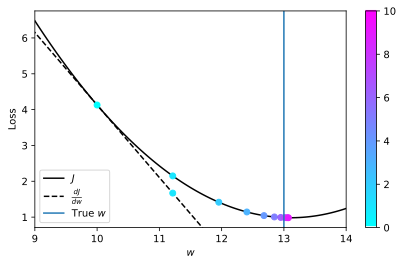

In [54]:
cmap = plt.get_cmap('cool')
learning_rate = .6
ws = np.linspace(9, 14, 101)
epochs = 10
w = 10

f, ax = plt.subplots(figsize=(7, 4))

def activate(w, b):
    Yhat = w * XnoInt + b
    J = ((Y-Yhat)**2).mean()
    dJ_dw = (2 * (Yhat - Y) * XnoInt).mean()
    dJ_db = (2 * (Yhat - Y)).mean()
    return Yhat, J, dJ_dw, dJ_db

# Show the loss function for our ws
plt.plot(ws, [activate(w, 7)[1] for w in ws], 'k', label='$J$')

# Plot the gradient at w_0
t = 0
Yhat, J, dJ_dw, dJ_db = activate(w, 7)
lim = 10
xlim, ylim = plt.xlim(), plt.ylim()
plt.plot([w-lim, w+lim], [J-lim*dJ_dw, J+lim*dJ_dw], '--', c='k', label='$\\frac{dJ}{dw}$')
plt.xlim(xlim)
plt.ylim(ylim)
h = learning_rate * dJ_dw
plt.plot(w-h, J-h*dJ_dw, 'o', c=cmap((t+1)/epochs))

# Gradient descent!
for t in range(epochs):
    Yhat, J, dJ_dw, dJ_db = activate(w, 7)
    plt.plot(w, J, 'o', c=cmap(t/epochs))
    w -= learning_rate * dJ_dw

plt.axvline(13, label='True $w$')

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=epochs), cmap=cmap)
sm.set_array(range(epochs))
f.colorbar(sm, ax=ax)
ax.set(ylabel='Loss', xlabel='$w$', xlim=[ws.min(), ws.max()])
plt.legend();

Now, we'll choose an arbitrary starting point and optimize both $w$ and $b$.

Estimate of w 12.588716148851423 Estimate of b 7.309673867183317


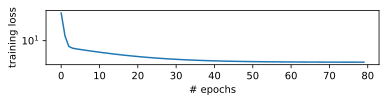

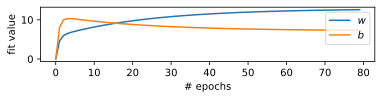

In [55]:
np.random.seed(42)
w = np.random.normal() * 1e-3
b = np.random.normal() * 1e-3

learning_rate = 0.3
history = []

for t in range(80):
    Yhat, J, dJ_dw, dJ_db = activate(w, b)
    history.append((w, b, J))
    w -= learning_rate * dJ_dw
    b -= learning_rate * dJ_db

print('Estimate of w', w, 'Estimate of b', b)

f, ax = plt.subplots(figsize=(6, 1))
plt.plot([h[2] for h in history])
plt.xlabel('# epochs')
plt.ylabel('training loss')
plt.yscale('log')

f, ax = plt.subplots(figsize=(6, 1))
plt.plot([h[0] for h in history], label='$w$')
plt.plot([h[1] for h in history], label='$b$')
plt.xlabel('# epochs')
plt.ylabel('fit value')
plt.legend()
None

Contemporary Machine Learning has developed really great tools for automatically taking derivatives of code. Here's an example of our above model optimized using `autograd`, an automatic differentiation library.

If you're curious about how automatic differentiation works, COS324 has [nice lecture notes](https://www.cs.princeton.edu/courses/archive/fall18/cos324/files/backprop.pdf) detailing implementation details. A simple method involves computing gradients at all steps of computation that can be stitched together using the Chain Rule.

Estimate [ 7.30968828 12.58868875]


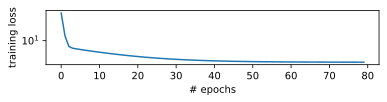

In [56]:
np.random.seed(42)
w = np.random.normal(size=2) * 1e-3

def loss(w):
    Yhat = X@w
    J = ((Y-Yhat)**2).mean()
    return J

grad_loss = autograd.grad(loss)

learning_rate = 0.3
history = []

for t in range(80):
    history.append(loss(w))
    w -= learning_rate * grad_loss(w)

print('Estimate', w)

f, ax = plt.subplots(figsize=(6, 1))
plt.plot(history)
plt.xlabel('# epochs')
plt.ylabel('training loss')
plt.yscale('log')
None

# Regression in practice

In practice, you might compute the above using `np.linalg.lstq`:

In [64]:
np.linalg.lstsq(X, Y, rcond=None)[0]

array([ 7.17478026, 12.84521484])

Or, with `sklearn`'s `LinearRegression`

In [65]:
import sklearn.linear_model
m = sklearn.linear_model.LinearRegression(fit_intercept=False)
m.fit(X, Y)
m.coef_

array([ 7.17478026, 12.84521484])

Or, for statistical analyses, with `statsmodels`, or `R`

In [76]:
import statsmodels.api as sm
m = sm.regression.linear_model.OLS(Y, X).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                 1.440e+04
Date:                Fri, 14 Aug 2020   Prob (F-statistic):               0.00
Time:                        17:26:20   Log-Likelihood:                -1406.3
No. Observations:                1000   AIC:                             2817.
Df Residuals:                     998   BIC:                             2826.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1748      0.061    117.463      0.0

In [79]:
%load_ext rpy2.ipython
%Rpush XnoInt
%Rpush Y

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [82]:
%%R
lm(Y ~ XnoInt)


Call:
lm(formula = Y ~ XnoInt)

Coefficients:
(Intercept)       XnoInt  
      7.175       12.845  



# Regularizing regression

Applications of regression will sometimes make use of regularization, which adds a term that penalizes large parameters. It would change our above loss function to this:

$$
J(w, b) = \frac{1}{m} \sum_{i=1}^m (\hat{y}_i-y_i)^2 + \lambda \left(w^2 + b^2\right)
$$

You can see that this invites a tradeoff in our objective; we want the error in our model to be low, but not if it requires making our parameters $w$ or $b$ too large. We can change $\lambda$ to tune this tradeoff; when $\lambda$ is large, we heavily regularize our parameters; as $\lambda$ becomes smaller, we give less priority to regularization; when $\lambda=0$, we do no regularization.

Regularization is advised when you have many features; it's worth thinking about what this means from the perspective of linear algebra. The standard regression equation $X^TXw=X^TY$ only admits a unique solution when $X^T X$ is invertible. Being invertible means that $X^T X$ has to be full rank. Since $rank(X)=rank(X^TX)$ ([proof here](https://math.stackexchange.com/questions/215145/rank-of-product-of-a-matrix-and-its-transpose)), then the rank of $X^TX$ is bounded by the dimensions of $X$, so $rank(X^TX) \le \min(m, n)$. Even though $X^T X$ is of size $n \times n$, if we have fewer samples than features (so, $m < n$), then it must be true that $rank(X^T X) \le m$.

The solution for regularized regression looks like this
$$(X^TX + \lambda I_n)w=X^TY$$

Since $I_n$ is full-rank (think about this for a second if you're not sure), when $\lambda>0$, the above ensures that $X^TX+\lambda I_N$ is invertible, so we have a unique solution!

If you think of the $X^T X$ term as an approximate feature covariance, then $I_n$ is a covariance matrix where different features do not covary! So you can also sort of think of regularization as moving you closer to the solution you'd expect with features that don't covary.

We won't do more to explore regularization, but it's worth noting that `sklearn` can perform this regularization in their [Ridge Regression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html).

# Logistic Function

One last thing I'll show you today is logistic regression. While it's a bit outside the scope of linear algebra, I think it's instructive to think of all the topics we're covering as being closely related & having relevance to each other. So, with a few small additions to our linear regression model, we'll be able to fit logistic regression models.

For background, logistic regression is used to predict categorical labels (like a choice between going left or right in a maze). To do this, we need a function that gives values between 0 and 1. We'll use the logistic or sigmoid function to accomplish this.

Below are a few logistic functions. You can change the steepness of the function (the gain, or $k$ below) as well as where it has the value 0.5 (the bias, or $x_0$ below). If we interpret the value from a sigmoid as a probability and round it to get a prediction, then the bias relates to the decision boundary!

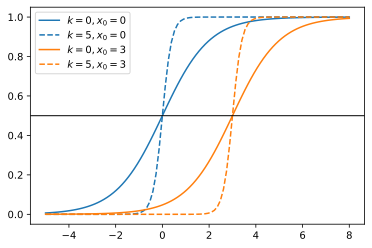

In [59]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

xs = np.linspace(-5, 8, 100)
l, = plt.plot(xs, sigmoid(xs), label='$k=0,x_0=0$')
plt.plot(xs, sigmoid(5*xs), label='$k=5,x_0=0$', c=l.get_color(), ls='--')
l, = plt.plot(xs, sigmoid(xs - 3), label='$k=0,x_0=3$')
plt.plot(xs, sigmoid(5*(xs - 3)), label='$k=5,x_0=3$', c=l.get_color(), ls='--')
plt.axhline(0.5, lw=1, c='k')
plt.legend();

Here's the equation for the sigmoid function $\sigma(z)$:

$$\sigma(z) = \frac{1}{1+e^{-z}}$$

To compute the above lines, we used $\sigma(k(x-x_0))$. If you let $w=k$ and $b=-kx_0$, then we can formulate this as a linear function followed by a logistic function $\sigma(wx+b)$.

_For the curious_: The logistic function is a special case of the softmax function over vectors of length 2.

## Logistic Regression

We can use the logistic function to compute things that live between 0 and 1, like probabilities or one-hot vectors (Is this a cat or not?). Combining this with linear regression means we can learn the gain and bias!

\begin{align}
z_i &= w x_i+b \\
\hat{y}_i &= \sigma(z_i) \\
\end{align}

While deriving the derivatives of the above isn't too tough & can be instructive, we'll skip it here (though [see here](https://github.com/2020-NEU502b/demos/blob/master/pdp-02/pdp-02.ipynb) for a tutorial I wrote that derives some of these things) and simply use `autograd` to compute them.

Here's a fake dataset of choice behavior. You'll notice this animal has preference for the left side. The logistic function gives us a compact way to characterize their choice behavior as a function of evidence, merely requiring that we specify which direction they prefer & how sharply their choice changes as a function of evidence. This is much nicer than having to deal with every single choice the animal made, or even their % of choice at varying levels of evidence.


Text(0, 0.5, '% Left')

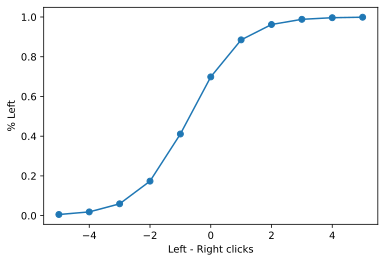

In [60]:
x0 = -0.7
k = 1.2
x = np.linspace(-5, +5, 11)
data = sigmoid(k*(x-x0))
plt.plot(x, data, '-o')
plt.xlabel('Left - Right clicks')
plt.ylabel('% Left')

Now we'll try to find the parameters of that data. We'll specify our loss as a function, compute the gradient, and use gradient descent. You'll note I haven't talked about what specific loss function we're using yet. While the appropriate thing to do is use the [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression), we'll simply compute the squared error.

Slope/Gain 1.18 Intercept 0.81 x_0 -0.69


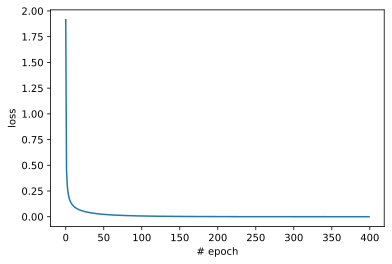

In [61]:
# Define our loss
def loss(w):
    z = x*w[0] + w[1]
    yhat = sigmoid(z)
    return ((data-yhat)**2).sum()
grad_loss = autograd.grad(loss)
learning_rate = 0.05

# Randomly initialize values
w = np.random.normal(size=2) * 1e-3

# Gradient descent!
history = []
for _ in range(400):
    J = loss(w)
    history.append(J)
    w -= learning_rate * grad_loss(w)

plt.plot(history)
plt.ylabel('loss')
plt.xlabel('# epoch')

print('Slope/Gain {:.02f} Intercept {:.02f} x_0 {:.02f}'.format(w[0], w[1], -w[1]/w[0]))

# References
- For much of this, I adapted exposition from my NUE502b lesson on related topics. Check it out if you want to see this extended to cover Neural Networks. https://github.com/2020-NEU502b/demos/blob/master/pdp-02/pdp-02.ipynb
- My notes on regularization are based on points made in Peter Ramadge's notes on Least Squares Regression and regularization.